# Datenanalyse: Heckrungenanlage – Produktions- und Störungsdaten

Dieses Notebook führt eine umfassende Analyse der Produktions- und Störungsdaten der Heckrungenanlage durch. Die Analyse gliedert sich in folgende Abschnitte:

1. **Daten laden & inspizieren** – Einlesen der Produktions- und Störungsdaten aus Excel-Dateien
2. **Mapping & Stationsübersicht** – Abgleich der Stationsbezeichnungen zwischen den Datensätzen
3. **Pareto-Analyse** – Identifikation der Stationen mit den höchsten Stillstandszeiten
4. **Micro-Stop-Analyse** – Untersuchung kurzer Unterbrechungen (≤ 5 Minuten)
5. **Produktionsmengen & Kennzahlen** – Überblick über produzierte Stückzahlen je Arbeitsplatz
6. **OEE-Daten & Effizienzanalyse** – Auswertung der Overall Equipment Effectiveness
7. **MCBF & Fehlerkaskaden** – Mean Cycles Between Failures und zeitnahe Störungsverkettungen
8. **Predictive Maintenance (ML)** – Maschinelles Lernen zur Vorhersage von Ausfallzeiten
9. **Soll-Ist-Vergleich** – Abweichungsanalyse je Produkt
10. **Korrelationsanalyse** – Zusammenhang zwischen Tagesproduktion und Störungsanzahl

---
## 1. Daten laden & inspizieren

Im ersten Schritt werden die beiden zentralen Datenquellen eingelesen:

- **`M200200 - Heckrungenanlage.XLSX`** – Enthält die Produktionsdaten mit Informationen zu Aufträgen, Serialnummern, Materialnummern, Arbeitsplätzen, Start-/Endzeiten und Soll-Vorgabewerten.
- **`Stoerliste_Heckrungenanlage_2023_NEU.xlsx`** – Enthält die Störungsliste mit Datum, Schicht, Dauer des Anlagenausfalls, betroffener Station/OP und Ursachenbeschreibung.

Anschließend wird die Struktur beider DataFrames untersucht (Spalten, Datentypen, fehlende Werte).

**Wichtig:** Die Spalte `DatumNEU` in den Störungsdaten enthält gemischte Datentypen (teils datetime, teils time-Objekte). Diese wird beim Laden direkt zu einem einheitlichen `datetime`-Format konvertiert, um spätere Fehler zu vermeiden.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

PROD_FILE = 'data/M200310 - STW_MT_Anlage.XLSX'
STOER_FILE = 'data/Störliste STW-Mittelteilanlage 2023_NEU.XLSX'

In [2]:
# Produktionsdaten laden (Sheet: Sheet1)
prod_df = pd.read_excel(PROD_FILE, sheet_name='Sheet1')

# Störungsdaten laden (Sheet: Aufschreibung)
stoer_df = pd.read_excel(STOER_FILE, sheet_name='Aufschreibung')

# DatumNEU enthält gemischte Typen (datetime + time-Objekte) -> einheitlich konvertieren
stoer_df['DatumNEU'] = pd.to_datetime(stoer_df['DatumNEU'], errors='coerce')

print(f"Produktionsdaten: {prod_df.shape[0]} Zeilen, {prod_df.shape[1]} Spalten")
print(f"Störungsdaten: {stoer_df.shape[0]} Zeilen, {stoer_df.shape[1]} Spalten")

Produktionsdaten: 16127 Zeilen, 27 Spalten
Störungsdaten: 7776 Zeilen, 37 Spalten


In [3]:
# Produktionsdaten inspizieren
print("--- Produktionsdaten Info ---")
prod_df.info()
prod_df.head()

--- Produktionsdaten Info ---
<class 'pandas.DataFrame'>
RangeIndex: 16127 entries, 0 to 16126
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Best.anforderung Pos.         8063 non-null   float64       
 1   Bestellanforderung            0 non-null      float64       
 2   Kundenauftragsnummer          8063 non-null   float64       
 3   Kundenauftragspos.            8063 non-null   float64       
 4   Serialnummer                  8063 non-null   str           
 5   ZE-Name                       8063 non-null   str           
 6   Auftragsnummer Verdichtung    0 non-null      float64       
 7   Auftrag                       16126 non-null  float64       
 8   Vorgang                       8063 non-null   float64       
 9   Materialnummer                8063 non-null   float64       
 10  Material-Text                 8063 non-null   str           
 11  Steuersch

,Best.anforderung Pos.,Bestellanforderung,Kundenauftragsnummer,Kundenauftragspos.,Serialnummer,ZE-Name,Auftragsnummer Verdichtung,Auftrag,Vorgang,Materialnummer,...,Istendzt.Durchf.,Vorgangsmenge (MEINH),Rückgem. Gutmenge (MEINH),Mengeneinheit Vrg. (=MEINH),Systemstatus,Vorgabewert 2 (VGE02),Vorgabewert 3 (VGE03),Vorgabewert Einheit (=VGE03),Userfeld 1 (10),Material-Text.1
0,0.0,NaN,30292926.0,510.0,302929260510,"Kaley Montagetechnik GmbH,Garrel",NaN,503882197.0,10.0,515121558.0,...,10:04:38,1,1,ST,RÜCK AUGB EIGP FREI RMST,0,17.01,MIN,STWROH,MV STW roh L4
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,503882197.0,NaN,NaN,...,NaN,1,1,ST,NaN,0,17.01,MIN,NaN,NaN
2,0.0,NaN,30292926.0,520.0,302929260520,"Kaley Montagetechnik GmbH,Garrel",NaN,503882201.0,10.0,515123277.0,...,15:05:13,1,1,ST,RÜCK AUGB EIGP FREI RMST,0,17.01,MIN,STWROH,MV Stirnwand roh L4
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,503882201.0,NaN,NaN,...,NaN,1,1,ST,NaN,0,17.01,MIN,NaN,NaN
4,0.0,NaN,30292926.0,530.0,302929260530,"Kaley Montagetechnik GmbH,Garrel",NaN,503882205.0,10.0,515123277.0,...,15:05:13,1,1,ST,RÜCK AUGB EIGP FREI RMST,0,17.01,MIN,STWROH,MV Stirnwand roh L4


In [4]:
# Störungsdaten inspizieren
print("--- Störungsdaten Info ---")
stoer_df.info()
stoer_df.head()

--- Störungsdaten Info ---
<class 'pandas.DataFrame'>
RangeIndex: 7776 entries, 0 to 7775
Data columns (total 37 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   Datum                                   7775 non-null   datetime64[us]
 1   Wochentag                               7745 non-null   object        
 2   DatumNEU                                7745 non-null   datetime64[us]
 3   KW                                      7745 non-null   object        
 4   Std.                                    2 non-null      datetime64[us]
 5   Log                                     2 non-null      datetime64[us]
 6   Schicht                                 7775 non-null   str           
 7   Zeit von                                7775 non-null   object        
 8   Zeit bis                                7775 non-null   object        
 9   Dauer
Arbeits-zeit                  

,Datum,Wochentag,DatumNEU,KW,Std.,Log,Schicht,Zeit von,Zeit bis,Dauer\nArbeits-zeit,...,Anlagen-Laufzeit\n(- Org-Mangel),Takt \nGesamt2,Leistung\nAnlage inkl. \nAnl. ausfall,Anlagen-Laufzeit\n(- Anlagen-ausfall),Takt \nGesamt3,Leistung eff.\nAnlage ohne\nAnl.-Ausfall,Produktionszeit(min)/Std.,Takt \nGesamt4,Leistung\n inkl.\ndefizite,Unnamed: 36
0,NaT,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2023-01-03,2,2023-01-03,2023/01,NaT,NaT,t,07:00:00,08:00:00,60.0,...,60.0,15.0,0.566667,40.0,10.0,0.85,40.0,10.0,0.85,0.0
2,2023-01-03,2,2023-01-03,2023/01,NaT,NaT,t,07:00:00,08:00:00,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,2023-01-03,2,2023-01-03,2023/01,NaT,NaT,t,07:00:00,08:00:00,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,2023-01-03,2,2023-01-03,2023/01,NaT,NaT,t,08:00:00,09:00:00,60.0,...,60.0,12.0,0.708333,50.0,10.0,0.85,50.0,10.0,0.85,0.0


---
## 2. Mapping & Stationsübersicht

Die Produktionsdaten verwenden das Feld **`Arbeitsplatz`** (z. B. `M200200`), während die Störungsdaten das Feld **`Station/ OP`** (z. B. `R 03`, `R 06`) nutzen. Um beide Datensätze miteinander verknüpfen zu können, muss zunächst geprüft werden, welche Stationsbezeichnungen existieren und ob es ein Mapping zwischen den beiden Namenskonventionen gibt.

Zusätzlich wird das **DropDown-Sheet** aus der Störungsliste ausgelesen, welches ein solches Mapping oder eine Auswahlliste enthalten kann.

In [5]:
# Mapping aus dem DropDown-Sheet prüfen
mapping_df = pd.read_excel(STOER_FILE, sheet_name='Aufschreibung', skiprows=1)
print("--- DropDown Mapping Beispiel ---")
display(mapping_df.head(20))

# Eindeutige Arbeitsplätze in den Produktionsdaten
print("\nEindeutige Arbeitsplätze in prod_df:")
print(prod_df['Arbeitsplatz'].unique())

# Eindeutige Stationen in den Störungsdaten
print("\nEindeutige Station/ OP in stoer_df:")
print(stoer_df['Station/ OP'].unique())

--- DropDown Mapping Beispiel ---


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,0
0,2023-01-03,2,2023-01-03,2023/01,NaT,NaT,t,07:00:00,08:00:00,60.0,...,60.0,15.000000,0.566667,40.0,10.000000,0.85,40.0,10.000000,0.85,0.0
1,2023-01-03,2,2023-01-03,2023/01,NaT,NaT,t,07:00:00,08:00:00,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,2023-01-03,2,2023-01-03,2023/01,NaT,NaT,t,07:00:00,08:00:00,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,2023-01-03,2,2023-01-03,2023/01,NaT,NaT,t,08:00:00,09:00:00,60.0,...,60.0,12.000000,0.708333,50.0,10.000000,0.85,50.0,10.000000,0.85,0.0
4,2023-01-03,2,2023-01-03,2023/01,NaT,NaT,t,08:00:00,09:00:00,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
5,2023-01-03,2,2023-01-03,2023/01,NaT,NaT,t,08:00:00,09:00:00,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6,2023-01-03,2,2023-01-03,2023/01,NaT,NaT,t,09:15:00,10:00:00,45.0,...,45.0,15.000000,0.566667,35.0,11.666667,0.728571,35.0,11.666667,0.728571,0.0
7,2023-01-03,2,2023-01-03,2023/01,NaT,NaT,t,09:15:00,10:00:00,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
8,2023-01-03,2,2023-01-03,2023/01,NaT,NaT,t,09:15:00,10:00:00,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
9,2023-01-03,2,2023-01-03,2023/01,NaT,NaT,t,10:00:00,11:00:00,60.0,...,60.0,10.000000,0.85,55.0,9.166667,0.927273,55.0,9.166667,0.927273,0.0



Eindeutige Arbeitsplätze in prod_df:
<StringArray>
['M200310', nan]
Length: 2, dtype: str

Eindeutige Station/ OP in stoer_df:
<StringArray>
[          nan,       'OP 50',        'R 07',       'OP 10',       'OP 30',
        'R 06',    'OP 130.2',        'R 05',        'R 02',   'R 06 R 07',
       'OP 25',        'R 03',       'OP 70',    'OP 120.1',      'OP 120',
    'OP 120.2',        'R 01',    'OP 10 Li',        'R.03',        'R.02',
        'R.05',        'R.07',         'R05',    'OP 130.1',       'OP 90',
    'Freitext',      'OP 100',        'R.06',       'R .01',    'op.130-2',
       'OP.01',       'OP.50',       'OP.10',       'OP.25',     'OP.10-R',
    'OP.130-1',       'R6/7 ',         'R07',    'OP.120-1',    'OP.130-2',
     'OP.1201',     'OP.10-L',        'OP10',        'OP50',        'OP90',
          'R5',        'OP20',     'OP130.1',         'R06',       'OP10 ',
       'OP.90',   'OP120/130', 'R.06 / R.07',        'R6/7',      'OP.110',
     'OP 10-L',     'O

In [7]:
# Detailansicht technische Störungen laden und inspizieren
detail_df = pd.read_excel(STOER_FILE, sheet_name='Aufschreibung', skiprows=9)
print("--- Detailansicht technische Störung ---")
display(detail_df.head())
print(detail_df.columns)

--- Detailansicht technische Störung ---


,2023-01-03 00:00:00,2,2023-01-03 00:00:00.1,2023/01,Unnamed: 4,Unnamed: 5,t,09:15:00,10:00:00,45.0,...,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,1.1
0,2023-01-03,2,2023-01-03,2023/01,NaT,NaT,t,09:15:00,10:00:00,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2023-01-03,2,2023-01-03,2023/01,NaT,NaT,t,10:00:00,11:00:00,60.0,...,60.0,10.000000,0.85,55.0,9.166667,0.927273,55.0,9.166667,0.927273,0.0
2,2023-01-03,2,2023-01-03,2023/01,NaT,NaT,t,10:00:00,11:00:00,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,2023-01-03,2,2023-01-03,2023/01,NaT,NaT,t,10:00:00,11:00:00,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,2023-01-03,2,2023-01-03,2023/01,NaT,NaT,t,11:00:00,12:00:00,60.0,...,60.0,8.571429,0.991667,55.0,7.857143,1.081818,55.0,7.857143,1.081818,0.0


Index([    2023-01-03 00:00:00,                       2,
       '2023-01-03 00:00:00.1',               '2023/01',
                  'Unnamed: 4',            'Unnamed: 5',
                           't',              '09:15:00',
                    '10:00:00',       45.00000000000048,
                             7,                       1,
                 'Unnamed: 12',                       3,
                         '3.1',           'Unnamed: 15',
                            10,           'Unnamed: 17',
                 'Unnamed: 18',           'Unnamed: 19',
                        'R 07',  'Probleme mit Gasdüse',
                 'Unnamed: 22',           'Unnamed: 23',
                 'Unnamed: 24',           'Unnamed: 25',
                 'Unnamed: 26',           'Unnamed: 27',
                 'Unnamed: 28',           'Unnamed: 29',
                 'Unnamed: 30',           'Unnamed: 31',
                 'Unnamed: 32',           'Unnamed: 33',
                 'Unnamed: 34',

---
## 3. Pareto-Analyse: Kritische Stationen identifizieren

Die **Pareto-Analyse** (auch 80/20-Regel) zeigt, welche Stationen den größten Anteil an der gesamten Stillstandszeit verursachen. Dazu werden die Störungsmeldungen nach Station gruppiert und die kumulierte Ausfallzeit berechnet.

**Ziel:** Die Top-20-Stationen identifizieren, die den Großteil der Stillstandszeit ausmachen. Oft verursachen wenige Stationen den Großteil der Ausfälle – hier lohnen sich Verbesserungsmaßnahmen am meisten.

Die Darstellung erfolgt als **Balkendiagramm** (absolute Stillstandszeit pro Station) kombiniert mit einer **kumulierten Prozentkurve**.

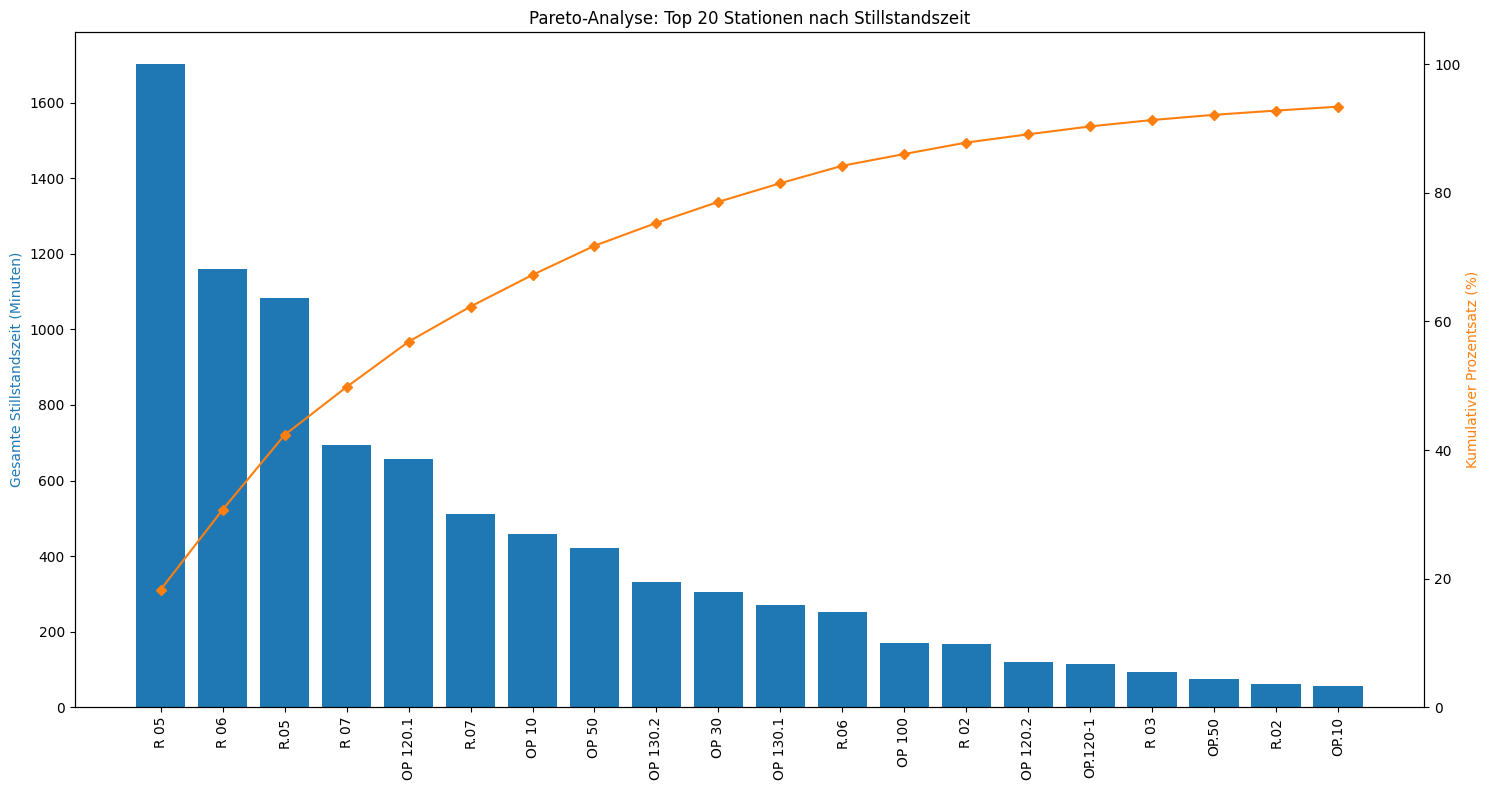

Top 10 kritischste Stationen:
Station/ OP
R 05        1702
R 06        1159
R.05        1083
R 07         695
OP 120.1     656
R.07         510
OP 10        459
OP 50        422
OP 130.2     332
OP 30        305
Name: Dauer\nAnlagen-Ausfall\n, dtype: object


In [8]:
# Daten bereinigen: Nur Zeilen mit gültiger Station und Ausfallzeit
stoer_clean = stoer_df.dropna(subset=['Station/ OP', 'Dauer\nAnlagen-Ausfall\n']).copy()

# Gesamte Stillstandszeit pro Station berechnen und absteigend sortieren
pareto_data = stoer_clean.groupby('Station/ OP')['Dauer\nAnlagen-Ausfall\n'].sum().sort_values(ascending=False)

# Pareto-Diagramm erstellen
fig, ax1 = plt.subplots(figsize=(15, 8))

ax1.bar(pareto_data.index[:20], pareto_data.values[:20], color="C0")
ax1.set_ylabel("Gesamte Stillstandszeit (Minuten)", color="C0")
ax1.tick_params(axis='x', rotation=90)

ax2 = ax1.twinx()
weights = pareto_data.values / pareto_data.sum()
cum_perc = weights.cumsum() * 100
ax2.plot(pareto_data.index[:20], cum_perc[:20], color="C1", marker="D", ms=5)
ax2.set_ylabel("Kumulativer Prozentsatz (%)", color="C1")
ax2.set_ylim(0, 105)

plt.title("Pareto-Analyse: Top 20 Stationen nach Stillstandszeit")
plt.tight_layout()
plt.show()

# Top 10 kritischste Stationen ausgeben
print("Top 10 kritischste Stationen:")
print(pareto_data.head(10))

---
## 4. Micro-Stop-Analyse

**Micro-Stopps** sind kurze Unterbrechungen (in der Regel ≤ 5 Minuten), die einzeln betrachtet unbedeutend erscheinen, in Summe aber einen erheblichen Produktivitätsverlust verursachen können.

In diesem Abschnitt wird untersucht:
- **Verteilung**: Ein Histogramm zeigt die Häufigkeitsverteilung aller Stillstandszeiten im Bereich 0–60 Minuten.
- **Anteil der Micro-Stopps**: Wie viele Störungen sind kürzer als 5 Minuten? Welchen Anteil machen sie an der Gesamtanzahl und an der Gesamt-Stillstandszeit aus?

Diese Analyse hilft zu entscheiden, ob ein Fokus auf die Reduzierung von Micro-Stopps sinnvoll ist.

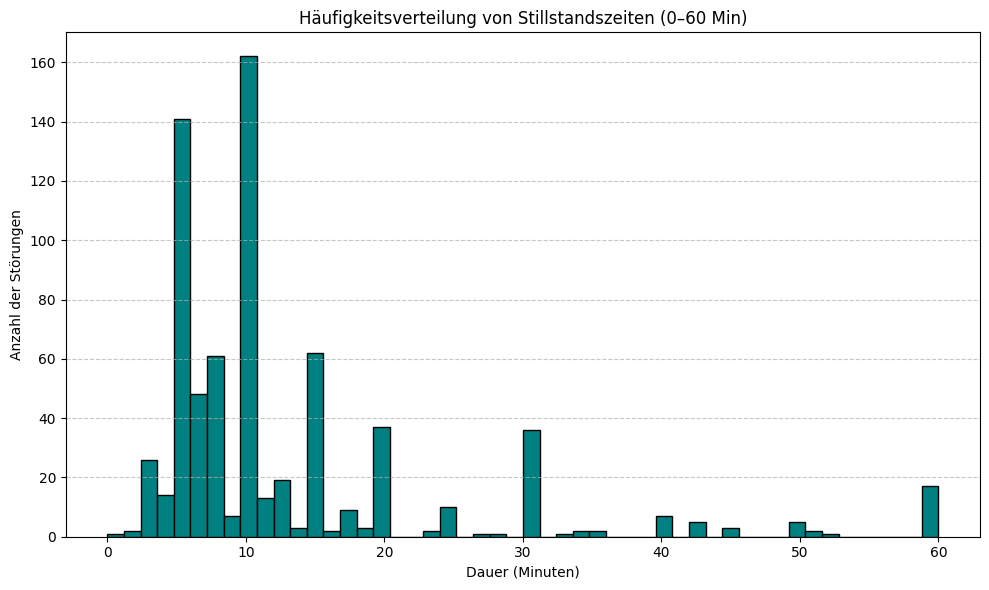

Anzahl Micro-Stopps (≤ 5 Min): 184
Anteil an Gesamtzahl der Störungen: 26.10%
Gesamtzeit Micro-Stopps: 844 Min
Anteil an Gesamt-Stillstandszeit: 9.06%


In [9]:
# Verteilung der Stillstandszeiten
durations = stoer_clean['Dauer\nAnlagen-Ausfall\n']

plt.figure(figsize=(10, 6))
plt.hist(durations, bins=50, range=(0, 60), color='teal', edgecolor='black')
plt.title("Häufigkeitsverteilung von Stillstandszeiten (0–60 Min)")
plt.xlabel("Dauer (Minuten)")
plt.ylabel("Anzahl der Störungen")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Statistiken für Micro-Stopps berechnen
micro_stops = durations[durations <= 5]
total_micro_duration = micro_stops.sum()
percentage_micro_time = (total_micro_duration / durations.sum()) * 100
percentage_micro_count = (len(micro_stops) / len(durations)) * 100

print(f"Anzahl Micro-Stopps (≤ 5 Min): {len(micro_stops)}")
print(f"Anteil an Gesamtzahl der Störungen: {percentage_micro_count:.2f}%")
print(f"Gesamtzeit Micro-Stopps: {total_micro_duration:.0f} Min")
print(f"Anteil an Gesamt-Stillstandszeit: {percentage_micro_time:.2f}%")

---
## 5. Produktionsmengen & Kennzahlen

Hier wird ein Überblick über die **produzierten Stückzahlen je Arbeitsplatz** gegeben. Außerdem werden die relevanten Felder aus der Störungsliste (Datum, Station, Stückzahl, Ausfallzeit) zur Plausibilitätsprüfung angezeigt.

Diese Daten bilden die Grundlage für weiterführende Kennzahlen wie den **MCBF** (Mean Cycles Between Failures).

In [10]:
# Relevante Spalten aus den Störungsdaten anzeigen
display(stoer_df[['Datum', 'Station/ OP', 'Menge   Gesamt\n(Stück)', 'Dauer\nAnlagen-Ausfall\n']].dropna().head(20))

# Produktionsmenge je Arbeitsplatz
prod_summary = prod_df.groupby('Arbeitsplatz')['Rückgem. Gutmenge (MEINH)'].sum()
print("\nProduktionsmenge je Arbeitsplatz:")
print(prod_summary)

,Datum,Station/ OP,Menge Gesamt\n(Stück),Dauer\nAnlagen-Ausfall\n
8,2023-01-03,R 07,3.0,10
10,2023-01-03,OP 50,6.0,5
22,2023-01-03,R 06,1.0,50
25,2023-01-03,R 07,1.0,45
32,2023-01-04,OP 130.2,3.0,10
35,2023-01-04,OP 50,2.0,8
36,2023-01-04,R 05,2.0,8
37,2023-01-04,R 05,4.0,10
38,2023-01-04,OP 50,4.0,10
40,2023-01-04,R 02,4.0,20



Produktionsmenge je Arbeitsplatz:
Arbeitsplatz
M200310    8063
Name: Rückgem. Gutmenge (MEINH), dtype: int64


---
## 6. OEE-Daten & Effizienzanalyse

Die **Overall Equipment Effectiveness (OEE)** ist eine zentrale Kennzahl in der Produktion und setzt sich aus drei Faktoren zusammen:
- **Verfügbarkeit** – Anteil der geplanten Produktionszeit, in der tatsächlich produziert wurde
- **Leistung** – Verhältnis von tatsächlicher zu theoretisch möglicher Produktionsgeschwindigkeit
- **Qualität** – Anteil der fehlerfreien Produkte

In diesem Abschnitt werden die vorberechneten OEE-Daten aus dem separaten Sheet geladen und mit den Produktionsdaten verknüpft. Zusätzlich wird die **Effizienz je Materialnummer** (Produkt) berechnet: Wie viel Soll-Zeit wurde je Produkt aufgewendet und wie viele Stück tatsächlich produziert?

In [11]:
# Effizienz je Produkt berechnen
product_perf = prod_df.groupby('Materialnummer').agg({
    'Vorgabewert 3 (VGE03)': 'sum', 
    'Rückgem. Gutmenge (MEINH)': 'sum'
}).rename(columns={'Vorgabewert 3 (VGE03)': 'Total_Soll_Time', 'Rückgem. Gutmenge (MEINH)': 'Total_Produced'})

# OEE-Daten aus separatem Sheet laden
oee_data = pd.read_excel(STOER_FILE, sheet_name='Aufschreibung', skiprows=2)
print("--- OEE Daten ---")
display(oee_data.head())

--- OEE Daten ---


,2023-01-03 00:00:00,2,2023-01-03 00:00:00.1,2023/01,Unnamed: 4,Unnamed: 5,t,07:00:00,08:00:00,60.0,...,59.99999999999898.1,14.99999999999975.1,0.5666666666666763.1,40.0,10.0,0.85,39.99999999999898.1,9.999999999999746.1,0.8500000000000216.1,0
0,2023-01-03,2,2023-01-03,2023/01,NaT,NaT,t,07:00:00,08:00:00,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2023-01-03,2,2023-01-03,2023/01,NaT,NaT,t,07:00:00,08:00:00,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,2023-01-03,2,2023-01-03,2023/01,NaT,NaT,t,08:00:00,09:00:00,60.0,...,60.0,12.0,0.708333,50.0,10.0,0.85,50.0,10.0,0.85,0.0
3,2023-01-03,2,2023-01-03,2023/01,NaT,NaT,t,08:00:00,09:00:00,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,2023-01-03,2,2023-01-03,2023/01,NaT,NaT,t,08:00:00,09:00:00,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


---
## 7. MCBF (Mean Cycles Between Failures) & Fehlerkaskaden

### 7a. MCBF – Mittlere Zyklen zwischen Ausfällen

Der **MCBF** gibt an, wie viele Produktionszyklen (Stück) im Durchschnitt zwischen zwei Ausfällen einer Station liegen. Ein hoher MCBF-Wert bedeutet eine zuverlässigere Station.

**Berechnung:** `MCBF = Gesamtproduktion (Station M200200) / Anzahl Störungen je Station`

### 7b. Fehlerkaskaden – Verkettete Störungen

Fehlerkaskaden treten auf, wenn ein Ausfall an einer Station innerhalb kurzer Zeit (hier: 30 Minuten) einen Ausfall an einer anderen Station nach sich zieht. Dies kann auf **mechanische Abhängigkeiten** oder **Materialfluss-Blockaden** zwischen Stationen hindeuten.

Die Analyse identifiziert die häufigsten **Stationspaare**, bei denen solche Verkettungen auftreten.

In [12]:
# MCBF berechnen
total_prod = prod_df[prod_df['Arbeitsplatz'] == 'M200200']['Rückgem. Gutmenge (MEINH)'].sum()
failure_counts = stoer_clean['Station/ OP'].value_counts()
mcbf = total_prod / failure_counts
print("--- MCBF (Mittlere Zyklen zwischen Ausfällen) ---")
print(mcbf.head(10))

# Fehlerkaskaden analysieren
# Zeitstempel erstellen: DatumNEU (bereits datetime) + Zeit von (string)
# DatumNEU ist jetzt datetime64, daher Datum extrahieren und mit Zeit kombinieren
stoer_clean['Timestamp'] = pd.to_datetime(
    stoer_clean['DatumNEU'].dt.strftime('%Y-%m-%d') + ' ' + stoer_clean['Zeit von'].astype(str), 
    errors='coerce'
)
stoer_sorted = stoer_clean.dropna(subset=['Timestamp']).sort_values('Timestamp')

# Zeitdifferenz zwischen aufeinanderfolgenden Störungen berechnen
stoer_sorted['Time_Diff'] = stoer_sorted['Timestamp'].diff().dt.total_seconds() / 60.0

# Kaskaden: Störungen innerhalb von 30 Minuten
cascades = stoer_sorted[stoer_sorted['Time_Diff'] < 30].copy()
cascades['Prev_Station'] = stoer_sorted['Station/ OP'].shift(1)
cascade_pairs = cascades.groupby(['Prev_Station', 'Station/ OP']).size().sort_values(ascending=False)

print("\n--- Häufigste Fehlerkaskaden (Stationspaare innerhalb 30 Min) ---")
print(cascade_pairs.head(10))

--- MCBF (Mittlere Zyklen zwischen Ausfällen) ---
Station/ OP
R 05        0.0
R 06        0.0
R 07        0.0
OP 10       0.0
R.05        0.0
OP 120.1    0.0
R.07        0.0
OP 50       0.0
R.06        0.0
OP 130.1    0.0
Name: count, dtype: float64

--- Häufigste Fehlerkaskaden (Stationspaare innerhalb 30 Min) ---
Prev_Station  Station/ OP
R 06          OP 10          7
OP 10         R 05           6
R 05          R 06           6
R.07          R.07           6
R 07          OP 10          6
OP 10         R 06           4
R 07          R 06           4
R 06          R 05           4
R.05          R.07           4
R.07          R.05           4
dtype: int64


---
## 8. Predictive Maintenance – Maschinelles Lernen

In diesem Abschnitt werden zwei **Machine-Learning-Modelle** trainiert, um zukünftige Ausfälle vorherzusagen:

### Modell 1: RUL-Vorhersage (Remaining Useful Life)
- **Ziel:** Vorhersage der verbleibenden Zeit bis zum nächsten Ausfall einer Station
- **Algorithmus:** Random Forest Regressor
- **Features:** Kodierte Station, Zeit seit dem letzten Ausfall
- **Bewertung:** R²-Score (je näher an 1, desto besser)

### Modell 2: Anomalie-Erkennung (Langer Stillstand)
- **Ziel:** Vorhersage, ob ein Ausfall zu einem langen Stillstand (> 30 Min) führen wird
- **Algorithmus:** Random Forest Classifier
- **Bewertung:** Accuracy (Anteil korrekt klassifizierter Fälle)

**Hinweis:** Die Modelle verwenden aktuell nur wenige Features und dienen als Proof-of-Concept. Für den produktiven Einsatz sollten zusätzliche Features (z. B. Schicht, Wochentag, Störungsursache, Produktionsvolumen) integriert werden.

In [13]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Daten für die Top-5-Stationen (nach Störungshäufigkeit) vorbereiten
top_stations = failure_counts.head(5).index.tolist()
df_ml = stoer_sorted[stoer_sorted['Station/ OP'].isin(top_stations)].copy()

# Feature: Zeit seit dem letzten Ausfall (pro Station)
df_ml['Prev_Timestamp'] = df_ml.groupby('Station/ OP')['Timestamp'].shift(1)
df_ml['Time_Since_Last_Fail'] = (df_ml['Timestamp'] - df_ml['Prev_Timestamp']).dt.total_seconds() / 60.0

# Zielvariable 1: Verbleibende Zeit bis zum nächsten Ausfall (RUL)
df_ml['Next_Timestamp'] = df_ml.groupby('Station/ OP')['Timestamp'].shift(-1)
df_ml['RUL'] = (df_ml['Next_Timestamp'] - df_ml['Timestamp']).dt.total_seconds() / 60.0

# Zielvariable 2: Langer Stillstand (> 30 Min) – binär
df_ml['Long_Downtime'] = (df_ml['Dauer\nAnlagen-Ausfall\n'] > 30).astype(int)

# Fehlende Werte entfernen (entstehen durch Shift-Operationen)
df_ml = df_ml.dropna(subset=['Time_Since_Last_Fail', 'RUL'])

# Station kodieren
le = LabelEncoder()
df_ml['Station_Enc'] = le.fit_transform(df_ml['Station/ OP'])
X = df_ml[['Station_Enc', 'Time_Since_Last_Fail']]

# --- Modell 1: RUL-Vorhersage ---
X_train, X_test, y_train, y_test = train_test_split(X, df_ml['RUL'], test_size=0.2, random_state=42)
model_rul = RandomForestRegressor(n_estimators=100)
model_rul.fit(X_train, y_train)

# --- Modell 2: Klassifikation langer Stillstand ---
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, df_ml['Long_Downtime'], test_size=0.2, random_state=42)
model_long = RandomForestClassifier(n_estimators=100)
model_long.fit(X_train2, y_train2)

print(f"RUL-Modell R²-Score: {model_rul.score(X_test, y_test):.4f}")
print(f"Anomalie-Erkennung Accuracy: {model_long.score(X_test2, y_test2):.4f}")

RUL-Modell R²-Score: -0.3354
Anomalie-Erkennung Accuracy: 0.9437


---
## 9. Soll-Ist-Vergleich: Effizienz je Produkt

Dieser Abschnitt vergleicht die **geplante Durchlaufzeit** (Soll, aus `Vorgabewert 3 (VGE03)`) mit der **tatsächlichen Durchlaufzeit** (Ist, berechnet aus den Zeitstempeln).

**Vorgehen:**
1. Aus `Istenddat.Durchf.` (datetime) und `Istendzt.Durchf.` (Zeitstring) wird ein vollständiger Zeitstempel erstellt.
2. Pro Serialnummer werden die Zeitstempel sortiert und die Differenz zwischen aufeinanderfolgenden Arbeitsschritten berechnet (= tatsächliche Bearbeitungszeit).
3. Die mittlere Ist-Dauer wird mit dem mittleren Soll-Wert je Arbeitsplatz verglichen.
4. Die **Abweichung** (Ist – Soll) zeigt, welche Arbeitsplätze deutlich länger brauchen als geplant.

**Interpretation:** Arbeitsplätze mit hoher positiver Abweichung verursachen Engpässe und sollten hinsichtlich ihrer Fertigungsprozesse überprüft werden.

In [ ]:
# Zeitstempel aus Enddatum und Endzeit zusammensetzen
# Istenddat.Durchf. ist datetime64, Istendzt.Durchf. ist ein Zeitstring
prod_df['End_TS'] = pd.to_datetime(
    prod_df['Istenddat.Durchf.'].dt.strftime('%Y-%m-%d') + ' ' + prod_df['Istendzt.Durchf.'].astype(str), 
    errors='coerce'
)

# Nach Serialnummer und Endzeit sortieren
prod_sorted = prod_df.dropna(subset=['End_TS', 'Serialnummer']).sort_values(['Serialnummer', 'End_TS'])

# Tatsächliche Bearbeitungszeit berechnen (Differenz zum vorherigen Schritt gleicher Serialnummer)
prod_sorted['Prev_End_TS'] = prod_sorted.groupby('Serialnummer')['End_TS'].shift(1)
prod_sorted['Actual_Duration'] = (prod_sorted['End_TS'] - prod_sorted['Prev_End_TS']).dt.total_seconds() / 60.0

# Nur positive Dauern berücksichtigen und Ausreißer filtern (max 480 Min = 8h)
efficiency_df = prod_sorted[(prod_sorted['Actual_Duration'] > 0) & (prod_sorted['Actual_Duration'] <= 480)]

# Mittlere Ist- und Soll-Dauer je Arbeitsplatz berechnen (aussagekräftiger als Material-Text)
product_eff = efficiency_df.groupby('Arbeitsplatz').agg({
    'Actual_Duration': 'mean',
    'Vorgabewert 3 (VGE03)': 'mean'
}).rename(columns={'Actual_Duration': 'Ist_Dauer_Mittel', 'Vorgabewert 3 (VGE03)': 'Soll_Dauer_Mittel'})
product_eff['Abweichung_Min'] = product_eff['Ist_Dauer_Mittel'] - product_eff['Soll_Dauer_Mittel']

print("--- Effizienz je Arbeitsplatz (Soll vs. Ist) ---")
display(product_eff.sort_values('Abweichung_Min', ascending=False))

---
## 10. Korrelationsanalyse: Produktion vs. Störungen

Zum Abschluss wird untersucht, ob ein **statistischer Zusammenhang** zwischen der täglichen Produktionsmenge und der Anzahl der Störungen besteht.

**Hypothese:** An Tagen mit höherer Produktionsauslastung treten möglicherweise mehr Störungen auf, da die Anlage stärker belastet wird.

Der **Pearson-Korrelationskoeffizient** gibt Aufschluss:
- Wert nahe **+1**: Starker positiver Zusammenhang (mehr Produktion → mehr Störungen)
- Wert nahe **0**: Kein linearer Zusammenhang
- Wert nahe **-1**: Starker negativer Zusammenhang

**Hinweis:** `DatumNEU` wurde beim Laden zu `datetime64` konvertiert und `Istenddat.Durchf.` ist ebenfalls `datetime64`. Damit matchen die Index-Typen beim Zusammenführen korrekt.

Übereinstimmende Tage: 90
Korrelation zwischen täglicher Produktion und Störungsanzahl: 0.1998


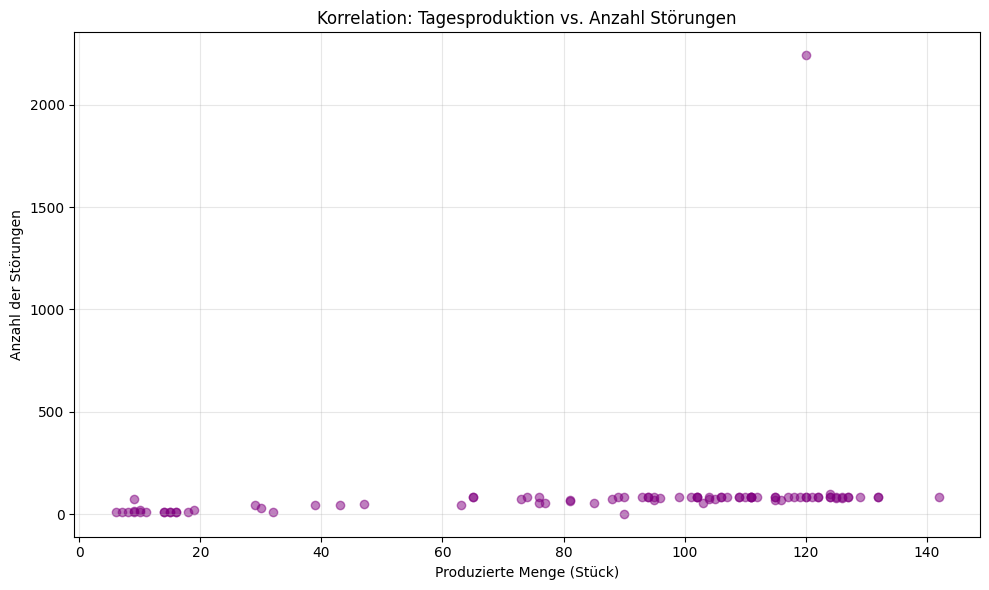

In [14]:
# Tägliche Produktionsmenge berechnen
# Istenddat.Durchf. ist datetime64 -> nur das Datum extrahieren für den Gruppierschlüssel
daily_prod = prod_df.groupby(prod_df['Istenddat.Durchf.'].dt.date)['Rückgem. Gutmenge (MEINH)'].sum()
daily_prod.index = pd.to_datetime(daily_prod.index)

# Tägliche Anzahl der Störungen berechnen
# DatumNEU ist jetzt datetime64 -> nur das Datum extrahieren
daily_fails = stoer_df.groupby(stoer_df['DatumNEU'].dt.date).size()
daily_fails.index = pd.to_datetime(daily_fails.index)

# DataFrames zusammenführen und Korrelation berechnen
corr_df = pd.DataFrame({'Production': daily_prod, 'Failures': daily_fails}).dropna()
print(f"Übereinstimmende Tage: {len(corr_df)}")

correlation = corr_df.corr().iloc[0, 1]
print(f"Korrelation zwischen täglicher Produktion und Störungsanzahl: {correlation:.4f}")

# Streudiagramm
plt.figure(figsize=(10, 6))
plt.scatter(corr_df['Production'], corr_df['Failures'], alpha=0.5, color='purple')
plt.title("Korrelation: Tagesproduktion vs. Anzahl Störungen")
plt.xlabel("Produzierte Menge (Stück)")
plt.ylabel("Anzahl der Störungen")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()